In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [2]:
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

In [3]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

print('The Dataset has a total of:')
print('\u2022 {:,} classes'.format(num_classes))
print('\u2022 {:,} images'.format(num_examples))

The Dataset has a total of:
• 2 classes
• 23,262 images


In [4]:
class_names = ['cat', 'dog']

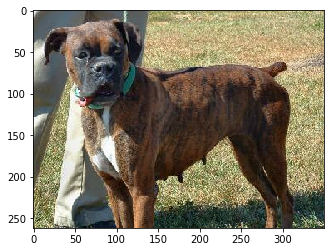

The label of this image is 1
The class name of this image is dog


In [5]:
for image, label in train_examples.take(1):
    image = image.numpy()
    label = label.numpy()
    
plt.imshow(image)
plt.show()

print(f"The label of this image is {label}")
print(f"The class name of this image is {class_names[label]}")

### Load the TF Hub Feature Vector

In [6]:
model_selection = ("mobilenet_v2", 224, 1280)

handle_base, pixels, FV_SIZE = model_selection
IMAGE_SIZE = (pixels, pixels)

MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)

feature_extractor = hub.KerasLayer(
    MODULE_HANDLE,
    input_shape=IMAGE_SIZE + (3,)
)
print(f"Using {handle_base} with input size {IMAGE_SIZE} and output dimension {FV_SIZE}.")

Using mobilenet_v2 with input size (224, 224) and output dimension 1280.


### Build Pipeline

In [7]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(BATCH_SIZE)

In [8]:
print(f"Building model with: {MODULE_HANDLE}")

model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2, activation="softmax")
])
model.summary()

Building model with: https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### (Optional) Perform Fine Tuning

In [9]:
do_fine_tuning = False

if do_fine_tuning:
    feature_extractor.trainable = True
else:
    feature_extractor.trainable = False

### Configure the Model for Training

In [10]:
if do_fine_tuning:
    optimizer = tf.keras.optimizers.SGD(lr=0.002, momentum=0.9)
else:
    optimizer = 'adam'
    
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [11]:
EPOCHS = 1
history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches
)

582/582 [==============================] - 380s 654ms/step - loss: 0.0541 - accuracy: 0.9815 - val_loss: 0.0389 - val_accuracy: 0.9862


In [ ]:
eval_results = model.evaluate(test_batches, verbose=0)

for metric, value in zip(model.metrics_name, eval_results):
    print(metric + ': {:.4}'.format(value))